# ETS

In [31]:
import numpy as np
import pandas as pd

#!wget -nc https://lazyprogrammer.me/course_files/sp500_close.csv
close = pd.read_csv('../datasets/sp500_close.csv', index_col=0, parse_dates=True)
close

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
2013-02-08,14.75,67.8542,78.90,36.25,46.89,34.41,73.31,39.12,45.70,30.22,...,37.51,28.24,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-11,14.46,68.5614,78.39,35.85,46.76,34.26,73.07,38.64,46.08,30.28,...,37.46,28.31,88.28,42.84,31.96,27.46,64.55,75.65,24.21,33.26
2013-02-12,14.27,66.8428,78.60,35.42,46.96,34.30,73.37,38.89,46.27,30.81,...,37.58,28.41,88.46,42.87,31.84,27.95,64.75,75.44,24.49,33.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-05,49.76,156.4900,109.86,109.51,91.90,58.73,151.83,190.27,85.40,40.60,...,66.97,37.68,79.72,58.54,31.38,72.66,79.80,123.18,51.65,73.83
2018-02-06,51.18,163.0300,112.20,111.20,91.54,58.86,154.69,194.47,88.54,42.00,...,68.99,37.34,78.35,58.46,30.85,71.33,80.58,122.30,52.52,73.27


## SMA

In [13]:
goog = close[['GOOG']].copy().dropna()


In [14]:
goog.head()


,GOOG
2014-03-27,558.46
2014-03-28,559.99
2014-03-31,556.97
2014-04-01,567.16
2014-04-02,567.00


<AxesSubplot: >

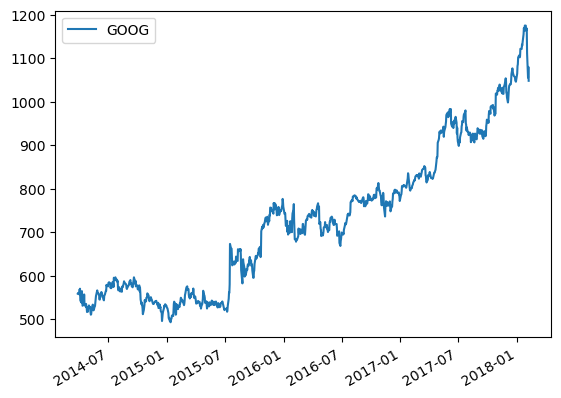

In [16]:
goog.plot()


In [17]:
goog_ret = np.log(goog.pct_change(1) + 1) #log return


<AxesSubplot: >

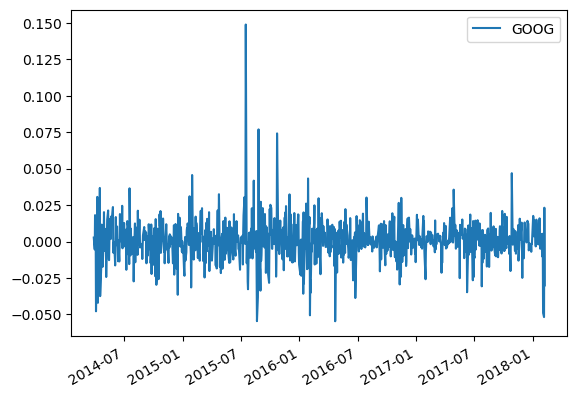

In [19]:
goog_ret.plot()


In [20]:
goog['SMA-10'] = goog['GOOG'].rolling(10).mean()
goog.head(20)

,GOOG,SMA-10
2014-03-27,558.46,NaN
2014-03-28,559.99,NaN
2014-03-31,556.97,NaN
2014-04-01,567.16,NaN
2014-04-02,567.00,NaN
2014-04-03,569.74,NaN
2014-04-04,543.14,NaN
2014-04-07,538.15,NaN
2014-04-08,554.90,NaN
2014-04-09,564.14,557.965


In [21]:
type(goog['GOOG'].rolling(10))


pandas.core.window.rolling.Rolling

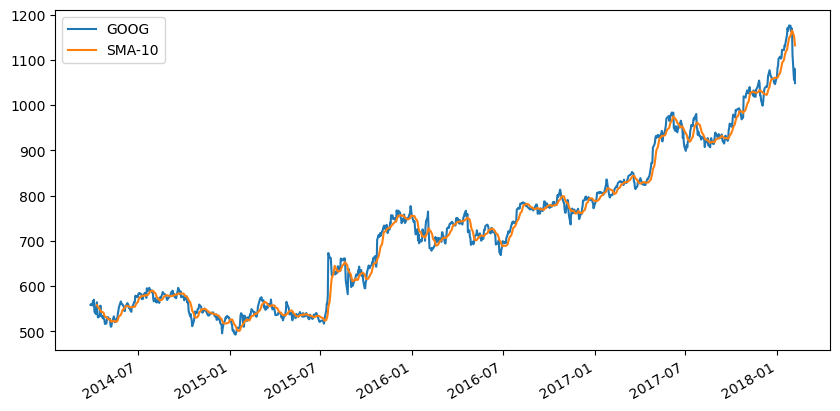

In [22]:
goog.plot(figsize=(10, 5));


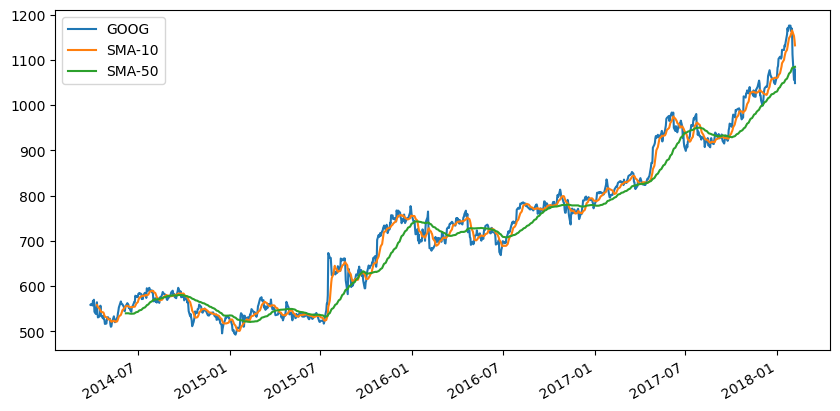

In [23]:
goog['SMA-50'] = goog['GOOG'].rolling(50).mean()
goog.plot(figsize=(10, 5));

In [24]:
goog_aapl = close[['GOOG', 'AAPL']].copy().dropna()
cov = goog_aapl.rolling(50).cov()
cov

GOOG       AAPL
2014-03-27 GOOG          NaN        NaN
           AAPL          NaN        NaN
2014-03-28 GOOG          NaN        NaN
           AAPL          NaN        NaN
2014-03-31 GOOG          NaN        NaN
...                      ...        ...
2018-02-05 AAPL    34.825709  17.568865
2018-02-06 GOOG  2691.756465  38.174468
           AAPL    38.174468  19.121371
2018-02-07 GOOG  2678.778214  49.980378
           AAPL    49.980378  22.052882

[1950 rows x 2 columns]

In [25]:
cov.loc['2018-02-07'].to_numpy()

array([[2678.77821424,   49.98037849],
       [  49.98037849,   22.05288249]])

In [26]:
goog_aapl_ret = np.log(1 + goog_aapl.pct_change(1))
goog_aapl_ret.head()

,GOOG,AAPL
2014-03-27,NaN,NaN
2014-03-28,0.002736,-0.001117
2014-03-31,-0.005408,-0.000223
2014-04-01,0.018130,0.009106
2014-04-02,-0.000282,0.001661


In [27]:
goog_aapl_ret['GOOG-SMA-50'] = goog_aapl_ret['GOOG'].rolling(50).mean()
goog_aapl_ret['AAPL-SMA-50'] = goog_aapl_ret['AAPL'].rolling(50).mean()

<AxesSubplot: >

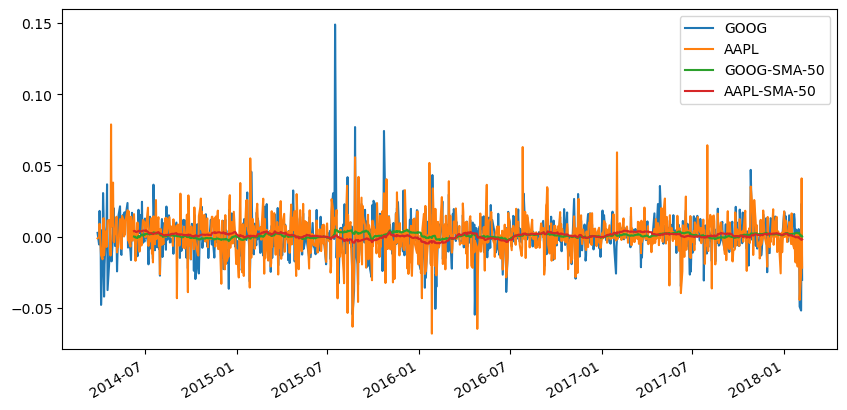

In [28]:
goog_aapl_ret.plot(figsize=(10, 5))

In [29]:
cov = goog_aapl_ret[['GOOG', 'AAPL']].rolling(50).cov()
cov.tail()

GOOG      AAPL
2018-02-05 AAPL  0.000110  0.000143
2018-02-06 GOOG  0.000193  0.000129
           AAPL  0.000129  0.000177
2018-02-07 GOOG  0.000212  0.000142
           AAPL  0.000142  0.000185

In [30]:
corr = goog_aapl_ret[['GOOG', 'AAPL']].rolling(50).corr()
corr.tail(16) #last 16

GOOG      AAPL
2018-01-29 GOOG  1.000000  0.531436
           AAPL  0.531436  1.000000
2018-01-30 GOOG  1.000000  0.525389
           AAPL  0.525389  1.000000
2018-01-31 GOOG  1.000000  0.515233
           AAPL  0.515233  1.000000
2018-02-01 GOOG  1.000000  0.510051
           AAPL  0.510051  1.000000
2018-02-02 GOOG  1.000000  0.671209
           AAPL  0.671209  1.000000
2018-02-05 GOOG  1.000000  0.681098
           AAPL  0.681098  1.000000
2018-02-06 GOOG  1.000000  0.700564
           AAPL  0.700564  1.000000
2018-02-07 GOOG  1.000000  0.716376
           AAPL  0.716376  1.000000

In [37]:
df = pd.read_csv('../datasets/AirPassengers.csv',  index_col = 'Month', parse_dates=True)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [38]:
df.isna().sum()


#Passengers    0
dtype: int64

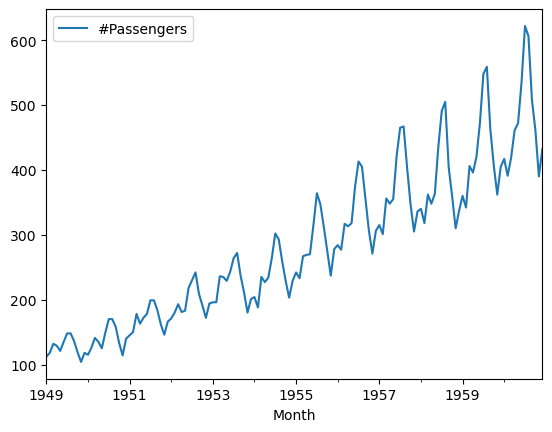

In [39]:
df.plot();


<AxesSubplot: xlabel='Month'>

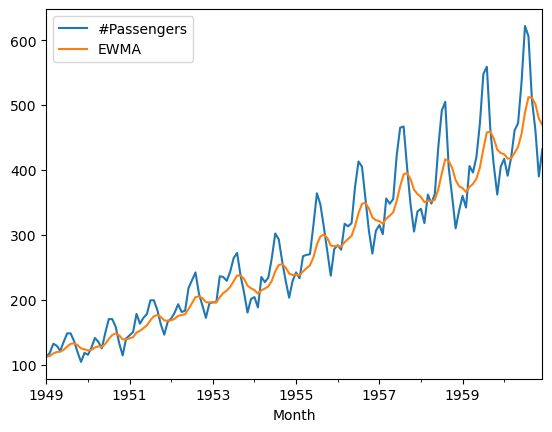

In [40]:
alpha = 0.2
df['EWMA'] = df['#Passengers'].ewm(alpha=alpha, adjust=False).mean()
type(df['#Passengers'].ewm(alpha=alpha, adjust=False))
df.plot()


In [42]:
manual_ewma = []
for x in df['#Passengers'].to_numpy():
  if len(manual_ewma) > 0:
    xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
  else:
    xhat = x
  manual_ewma.append(xhat)
df['Manual'] = manual_ewma

<AxesSubplot: xlabel='Month'>

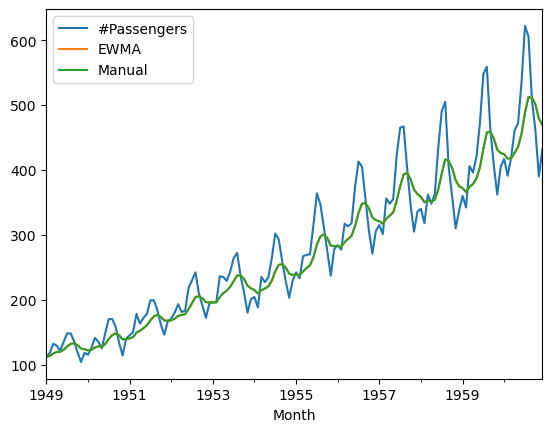

In [44]:
df.plot()


In [45]:
df.head()


,#Passengers,EWMA,Manual
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,113.2000,113.2000
1949-03-01,132,116.9600,116.9600
1949-04-01,129,119.3680,119.3680
1949-05-01,121,119.6944,119.6944


In [46]:
df.drop('Manual', axis=1, inplace=True)
